# Subscription Covariates Model

Models such as `BetaGeoNBDModel` work well for retail transactions, but subscription renewals require a different approach. In ["Incorporating Time-Varying Covariates in
a Simple Mixture Model for
Discrete-Time Duration Data"](https://www.brucehardie.com/notes/037/time-varying_covariates_in_BG.pdf), Fader & Hardie propose an ideal model for this very purpose. The research note derives a model supporting time-varying covariates, but with this [methodology](https://brucehardie.com/notes/019/time_invariant_covariates.pdf), it can be easily extended to support static covariates as well.


### Setup Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sb
import xarray as xr
from fastprogress.fastprogress import progress_bar
import pymc as pm
import pytensor as pt
from scipy.stats import describe

from pymc_marketing import clv
from pymc_marketing.prior import Prior

In [2]:
# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed = sum(map(ord, "Subscription Covariates Model"))
rng = np.random.default_rng(seed)

### Generate Data
We will be recreating the test dataset from the [`ShiftedBetaGeoModelIndividual` notebook](https://www.pymc-marketing.io/en/stable/notebooks/clv/sBG.html) for comparison. This dataset consists of 2,000 customers in two groups - Regular and High-end. Both groups contain 1,000 customers.

The following dataframe contains the percent of customers still active in each time period for both groups:

In [4]:
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

regular  highend
0     100.0    100.0
1      63.1     86.9
2      46.8     74.3
3      38.2     65.3
4      32.6     59.3
5      28.9     55.1
6      26.2     51.7
7      24.1     49.1
8      22.3     46.8
9      20.7     44.5
10     19.4     42.7
11     18.3     40.9
12     17.3     39.4

Note time period 0 is specific to each customer: Time 0 for one customer may be Oct 2024, and Time 0 for another could be Jan 2025. It is the responsibility of the user to index the modeling data by the number of active time periods for each customer. The first seven time periods will be used for model fitting, and the remaining 6 for validation.

*clarify this paragraph with AI:* The lack of a unified time index for all customers may seem unusual at first, but it greatly improves model flexibility! We can allow the time-varying covariates to define the month-to-month characteristics for each customer. It is also very common for individual customers to start and renew their subscriptions on different days of the month, so we are not restricted to a cohort-style analysis that assigns customers to rigid time periods.

The next three cells contain a data generation function, which is then parametrized to create the regular and highend customers. Both customer groups are then concatenated into a `pandas` dataframe for modeling.

In [5]:
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)

    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter : counter + diff] = t
        counter += diff

    censoring_t = t + 1
    died_at[counter:] = censoring_t

    return died_at

In [6]:
T = 8  # In the paper only the first 7 years (plus current year) are included in the model.

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(
    truncated_df["highend"], initial_customers
)
churn_regular = individual_data_from_percentage_alive(
    truncated_df["regular"], initial_customers
)

In [7]:
dataset_highend = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers),
        "t_churn": churn_highend,
        "T": T,
        "group": "highend",
    }
)

dataset_regular = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers),
        "t_churn": churn_regular,
        "T": T,
        "group": "regular",
    }
)

dataset = pd.concat([dataset_highend,dataset_regular])

dataset[::200]

customer_id  t_churn  T    group
0              0        1  8  highend
200          200        2  8  highend
400          400        4  8  highend
600          600        8  8  highend
800          800        8  8  highend
0              0        1  8  regular
200          200        1  8  regular
400          400        2  8  regular
600          600        3  8  regular
800          800        8  8  regular

# Model Fitting

Fader & Hardie refer to this model as the Grassia(II)-Geometric + covariates model. It has the following assumptions:

1. Customers are active for a discrete number of $t$ subscription periods, then permanently cancel their subscription at time period $T$.
   
2. Difference between customers are characterized by a Gamma distribution with shape $r$ and scale $\alpha$.
   
3. Time-varying covariates for each customer are described by $C(t)$:
   $$C(t)=\sum_{j=1}^{t} e^{z(j)\beta}$$
   Where $z(j)$ denotes the vector of covariates at time $j$, and $\beta$ the coefficients for these covariates. If no covariates are specified, this expression reduces to $t$.
   
4. Parameters $r$, $\alpha$, and $\beta$ do not vary over time.
   
5. Random variable $T$ for subscription cancellations is described by the following following probability mass function:
    $$P(T(=t|r,\alpha,\beta;Z(t)) = (\frac{\alpha}{\alpha+C(t-1)})^{r} - (\frac{\alpha}{\alpha+C(t)})^{r} $$

6. The probability a customer is still active in time period $t$ is characterized by the following survival function:
   $$S(t|r,\alpha,\beta;Z(t)) = (\frac{\alpha}{\alpha+C(t)})^{r} $$

7. To include static covariates, simply modify the $\alpha$ parameter as shown:
   $$\alpha=\alpha_0e^{-\gamma*x} $$
   Where $x$ denotes the static covariate arrays for each customer, with $\gamma$ coefficients capturing covariate impacts. 

For detailed derivations of this model, refer back to the research notes.

# TUTORIAL SECTION ENDS HERE 
# ALL CELLS FROM THIS POINT ONWARD FOR MODEL DEV ONLY

# Plot PMF

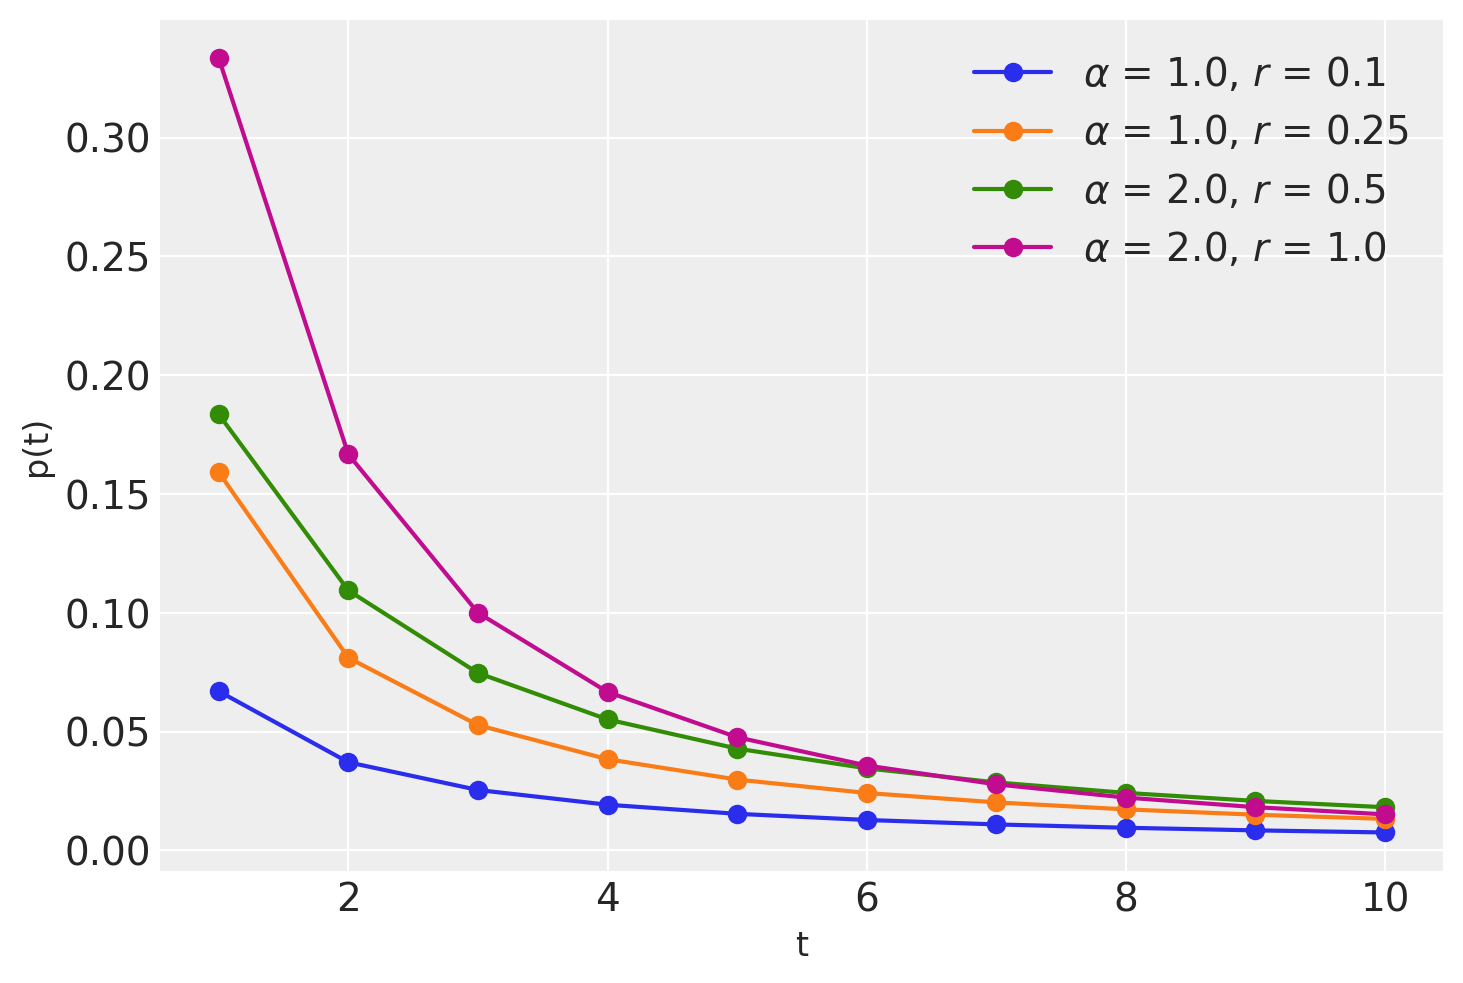

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
t = np.arange(1, 11)
alpha_vals = [1., 1., 2., 2.]
r_vals = [.1, .25, .5, 1.]
for alpha, r in zip(alpha_vals, r_vals):
    pmf = (alpha/(alpha + t - 1))**r - (alpha/(alpha+t))**r
    plt.plot(t, pmf, '-o', label=r'$\alpha$ = {}, $r$ = {}'.format(alpha, r))
plt.xlabel('t', fontsize=12)
plt.ylabel('p(t)', fontsize=12)
plt.legend(loc=1)
plt.show()


# Model Fit with `pm.Censored` and Full Dataset
We can define a model for right-censored data by including the Survivor Function with `pm.Potential`, but using `pm.Censored` is preferred.

In [8]:
# TODO: Add a dim hierarchical support of both regular and highend groups
coords ={
    "customer_id": dataset["customer_id"],
}

with pm.Model(coords=coords) as model:

    # Independent priors
    # alpha = pm.Gamma("alpha",alpha=3,beta=1)
    # r = pm.Gamma("r", alpha=1,beta=1)

    # Are pooled priors more stable?
    phi = pm.Uniform("phi",lower=0,upper=1)
    kappa = pm.Pareto("kappa",alpha=1,m=1) #m is an intuitive lower bound for alpha

    alpha=pm.Deterministic("alpha", phi * kappa)
    r=pm.Deterministic("r", (1-phi) * kappa)

    churn_raw = clv.distributions.GrassiaIIGeometric.dist(r=r, alpha=alpha)
    cens = pm.Censored(
        "censored",
        churn_raw,
        lower=None,
        upper=dataset["T"],
        observed = dataset["t_churn"],
        dims=("customer_id",),
    )

    idata = pm.sample(idata_kwargs={"log_likelihood": True})
    
# These lines are not required for notebook dev, but should be tested after source code is built
    # idata = pm.sample_prior_predictive()
    
    # idata.extend(
    #     pm.sample(random_seed=seed, idata_kwargs={"log_likelihood": True})
    # )
    # idata.extend(pm.sample_posterior_predictive(idata))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.784  2.611     1.0    3.181      0.065    0.046     945.0     855.0   
kappa  1.785  2.611     1.0    3.181      0.065    0.046     945.0     842.0   
phi    1.000  0.000     1.0    1.000      0.000    0.000    1511.0    1470.0   
r      0.000  0.000     0.0    0.000      0.000    0.000    1849.0    1533.0   

       r_hat  
alpha    1.0  
kappa    1.0  
phi      1.0  
r        1.0

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

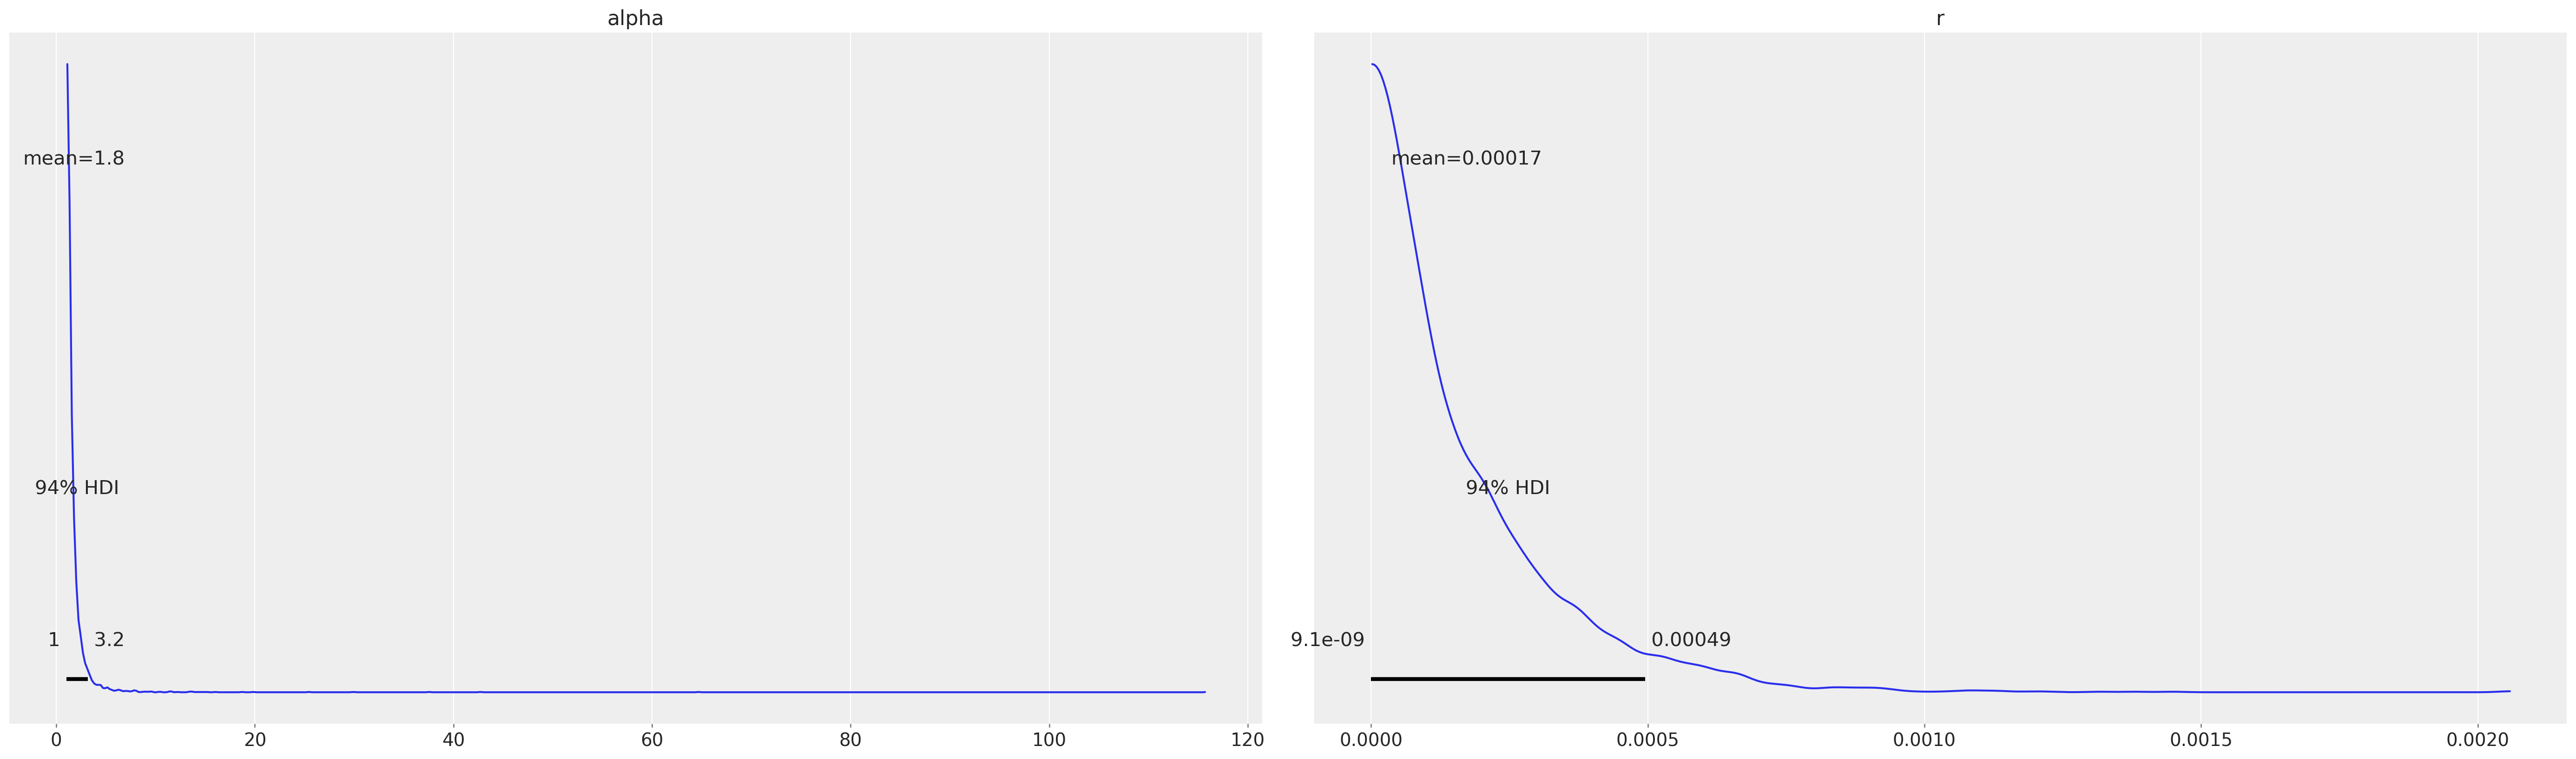

In [10]:
az.plot_posterior(idata, var_names=["alpha","r"])

*Don't worry about the sampling divergences yet.* Recall this is a small dataset comprised of two equally-sized - and very different - customer groups. The same model converges just fine when using informative, independent priors. This is an ideal application to extend the model further for hierarchical support, but to replicate `ShiftedBetaGeoModelIndividual` results, we'll proceed with fitting two separate models for now.

Although `pm.Censored` will be used in the source code, it requires additional boilerplate for prior/posterior predictive checks and writing that code here would result in duplicated work. However, we can do crude-but-quick PPCs in this notebook with `pm.Potential`, which still has comparable results for notebook testing despite being less stable.

Define $log(S(t)$ for testing with `pm.Potential`:

In [95]:
def log_survival_fn(r, alpha, t):
    return r * (pt.tensor.log(alpha) - pt.tensor.log(alpha + t))

Split the dataset and create censoring masks:

In [93]:
reg_data = dataset[dataset["group"]=="regular"].copy()
reg_censored = reg_data["t_churn"] == reg_data["T"]

hi_data = dataset[dataset["group"]=="highend"].copy()
hi_censored = hi_data["t_churn"] == hi_data["T"]

# Model Fit with `pm.Potential` and Regular Customers

In [136]:
coords = {
    "churn_customer": reg_data["customer_id"][~reg_censored],
    "active_customer": reg_data["customer_id"][reg_censored],
}

with pm.Model(coords=coords) as model:
    # Independent priors
    # alpha = pm.Gamma("alpha",alpha=1,beta=1)
    # r = pm.Gamma("r", alpha=1,beta=1)

    # Are pooled priors more stable?
    phi = pm.Uniform("phi",lower=0,upper=1)
    kappa = pm.Pareto("kappa",alpha=1,m=1) #m is starting point, and could be good way to constrain to prevent crashes

    alpha=pm.Deterministic("alpha", phi * kappa)
    r=pm.Deterministic("r", (1-phi) * kappa)
    
    churn_raw = clv.distributions.GrassiaIIGeometric("churn",r=r, alpha=alpha, observed = reg_data["t_churn"][~reg_censored], dims=("churn_customer",))
    cens = pm.Potential("censored",log_survival_fn(r, alpha, reg_data["t_churn"][reg_censored]), dims=("active_customer",))

    idata = pm.sample(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


### Diagnostics and Posterior Predictive Check

In [137]:
az.summary(idata)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.768  2.42   0.998    3.341      0.044    0.031    1580.0    1867.0   
kappa  1.768  2.42   1.000    3.341      0.044    0.031    1578.0    1895.0   
phi    1.000  0.00   0.999    1.000      0.000    0.000    1492.0    1086.0   
r      0.000  0.00   0.000    0.001      0.000    0.000    1723.0    1205.0   

       r_hat  
alpha    1.0  
kappa    1.0  
phi      1.0  
r        1.0

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

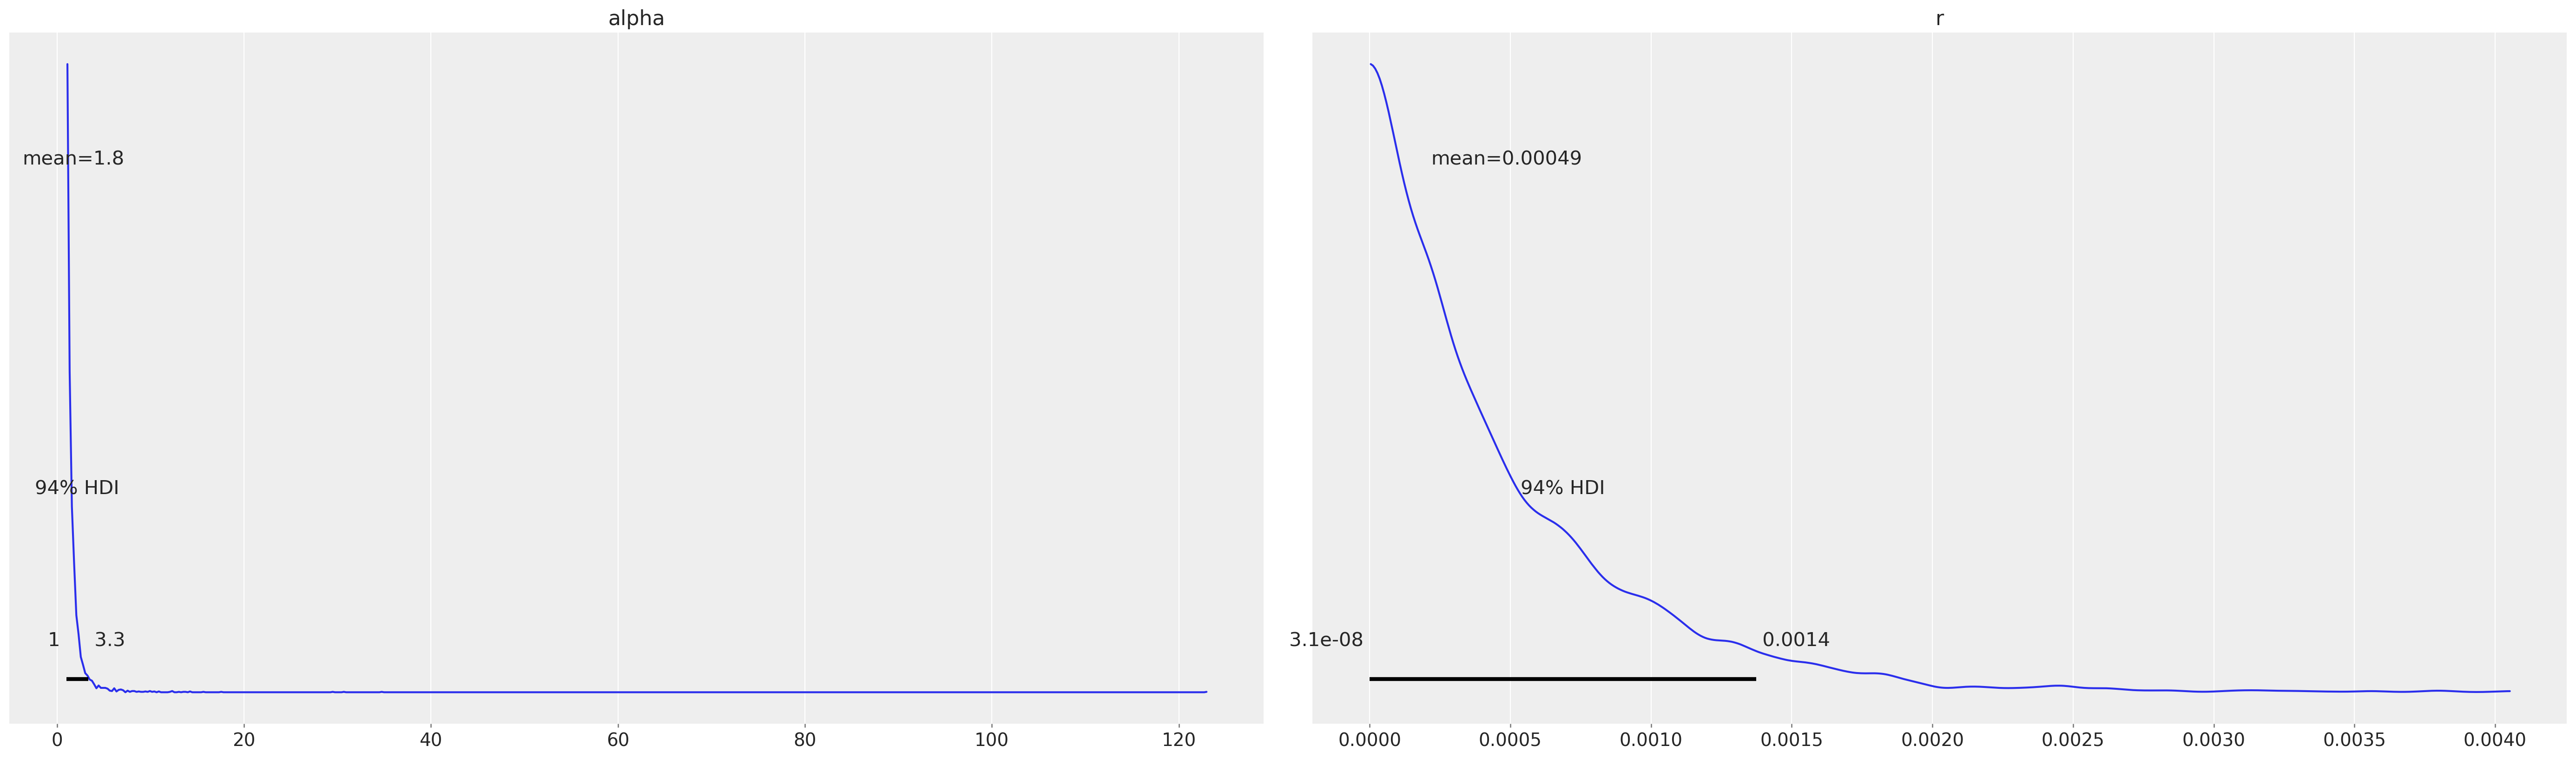

In [138]:
az.plot_posterior(idata, var_names=["alpha","r"])

In [139]:
with model:
    ppc = pm.sample_posterior_predictive(idata)

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_46755/842823906.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(idata)
Sampling: [churn]


Output()

In [149]:
# TODO: Do a pandas plot of this!
clipped_ppc_val

array([ 3, 95, 47, ...,  4,  3, 68])

data describe: DescribeResult(nobs=3036000, minmax=(1, 1897118), mean=99565.63457411068, variance=9991387130.892487, skewness=1.9964339281860444, kurtosis=5.980742225852408)


Text(0.5, 1.0, 'Synthetic PPC')

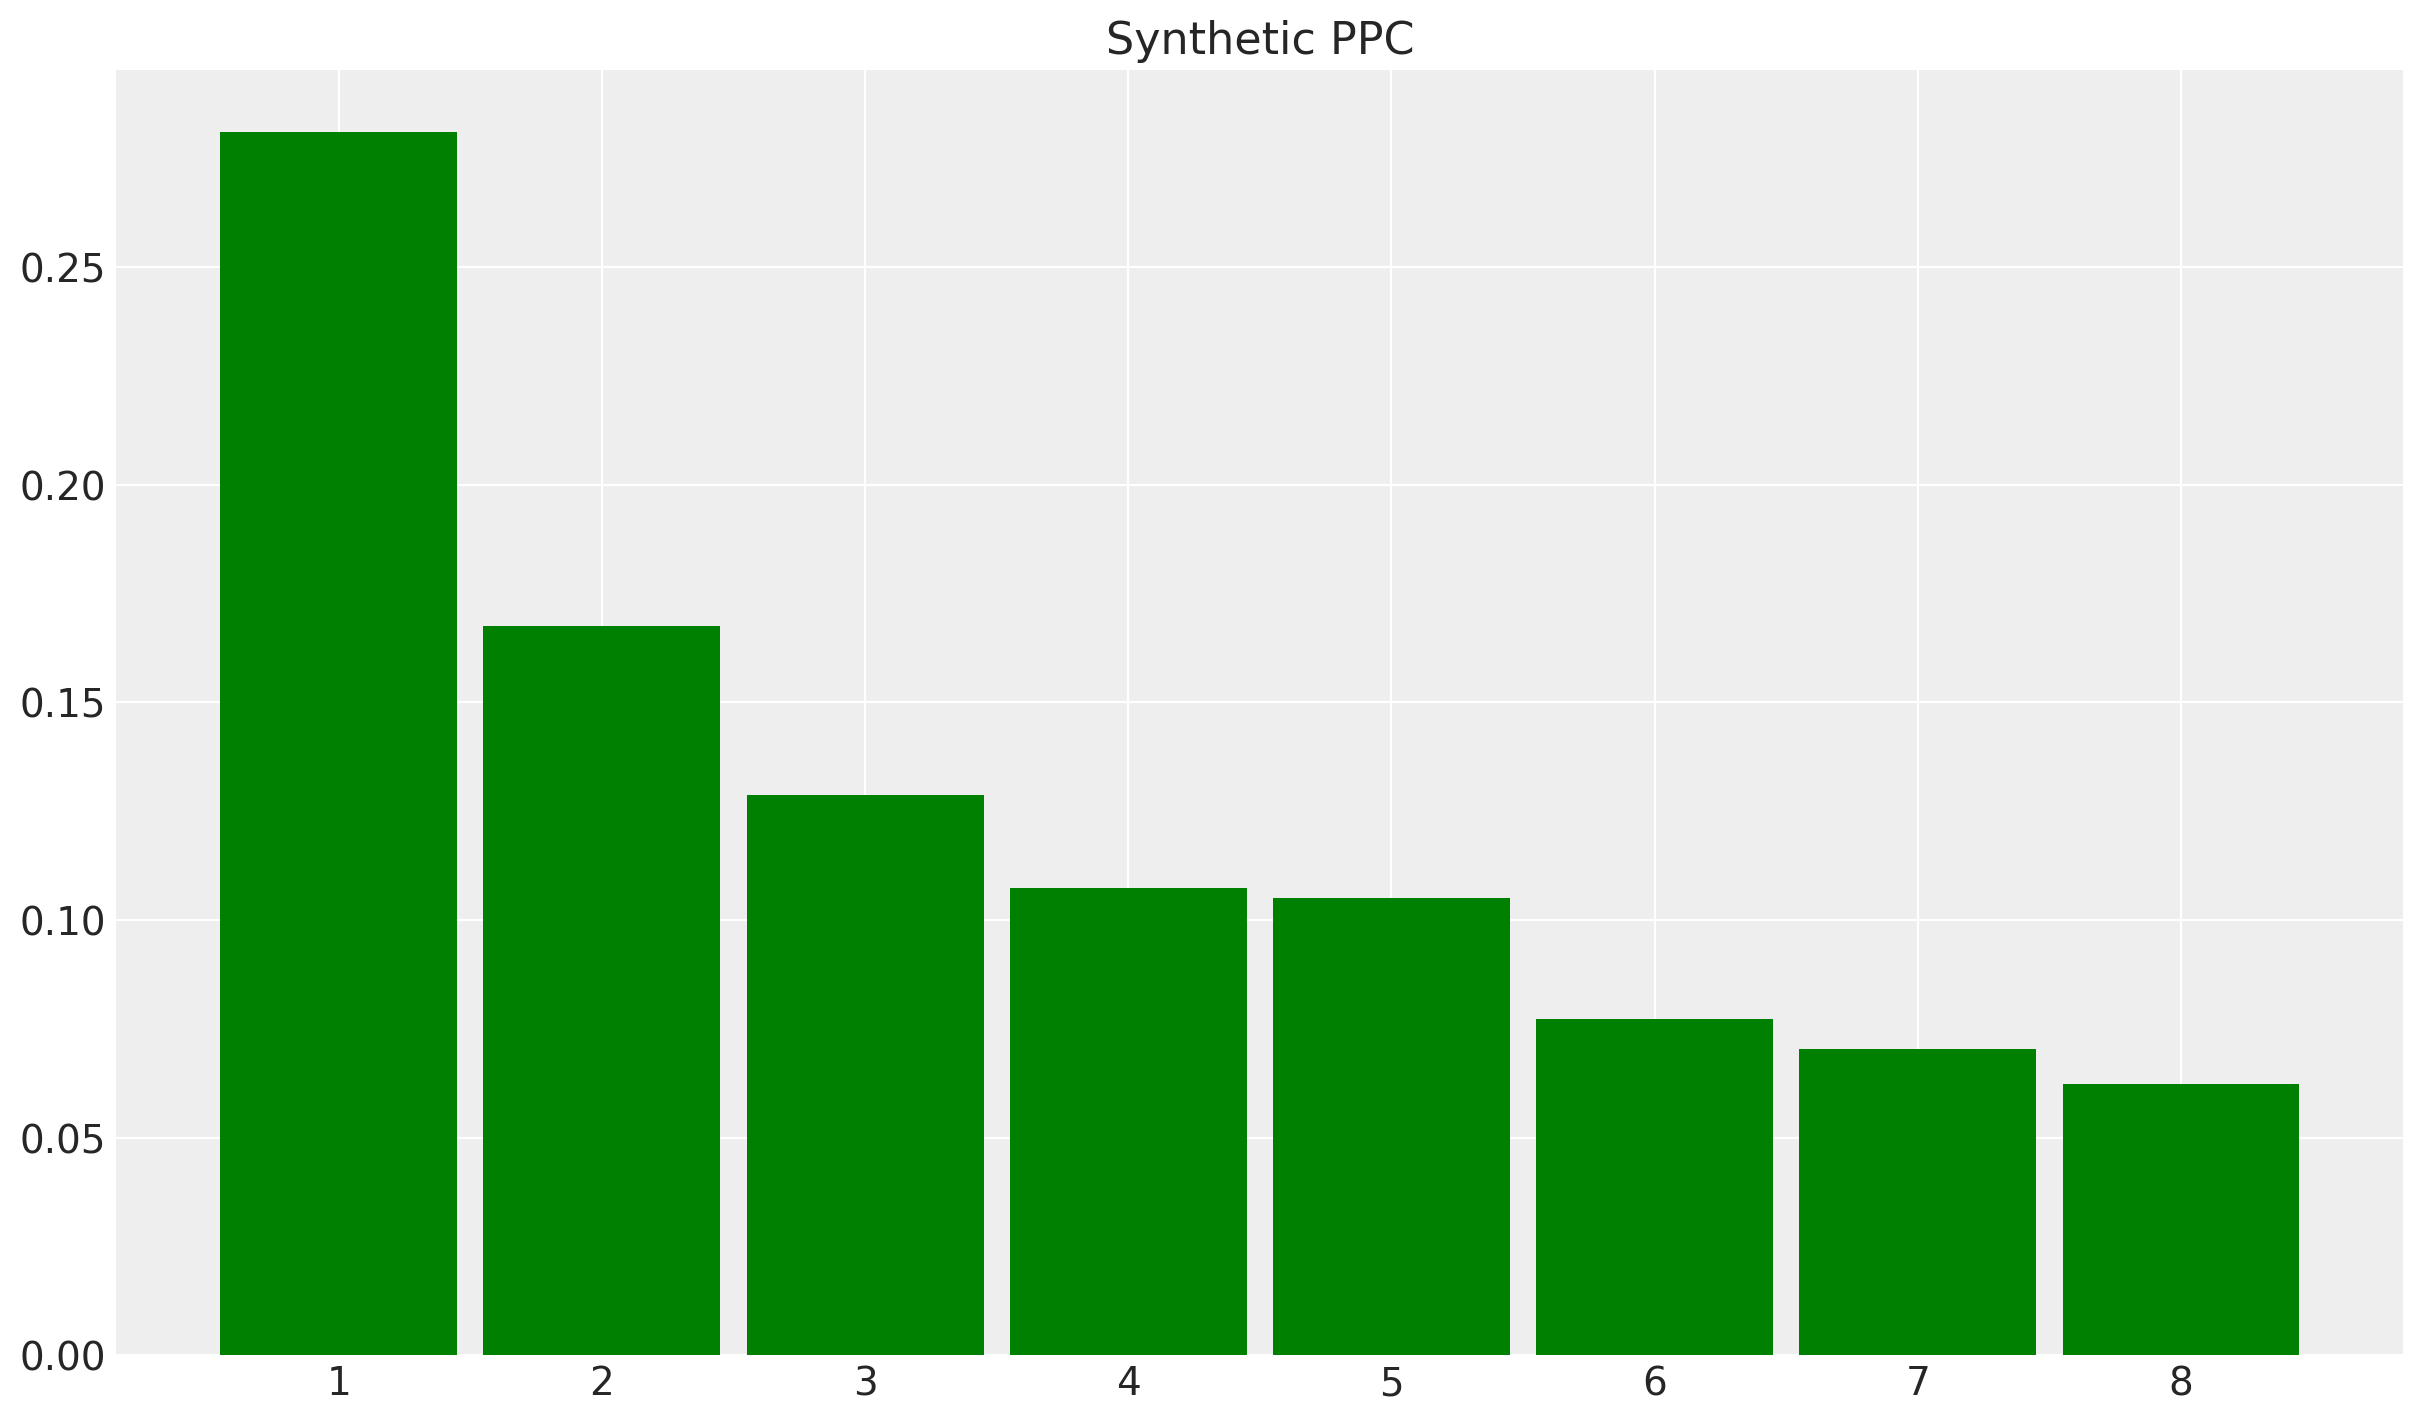

In [147]:
ppc_val = ppc.posterior_predictive["churn"].values.flatten()

print(f"data describe: {describe(ppc_val)}")

clipped_ppc_val = ppc_val[ppc_val<100]

az.plot_dist(ppc_val[ppc_val<9],color='green').set_title("Synthetic PPC")

Text(0.5, 1.0, 'Observed PPC')

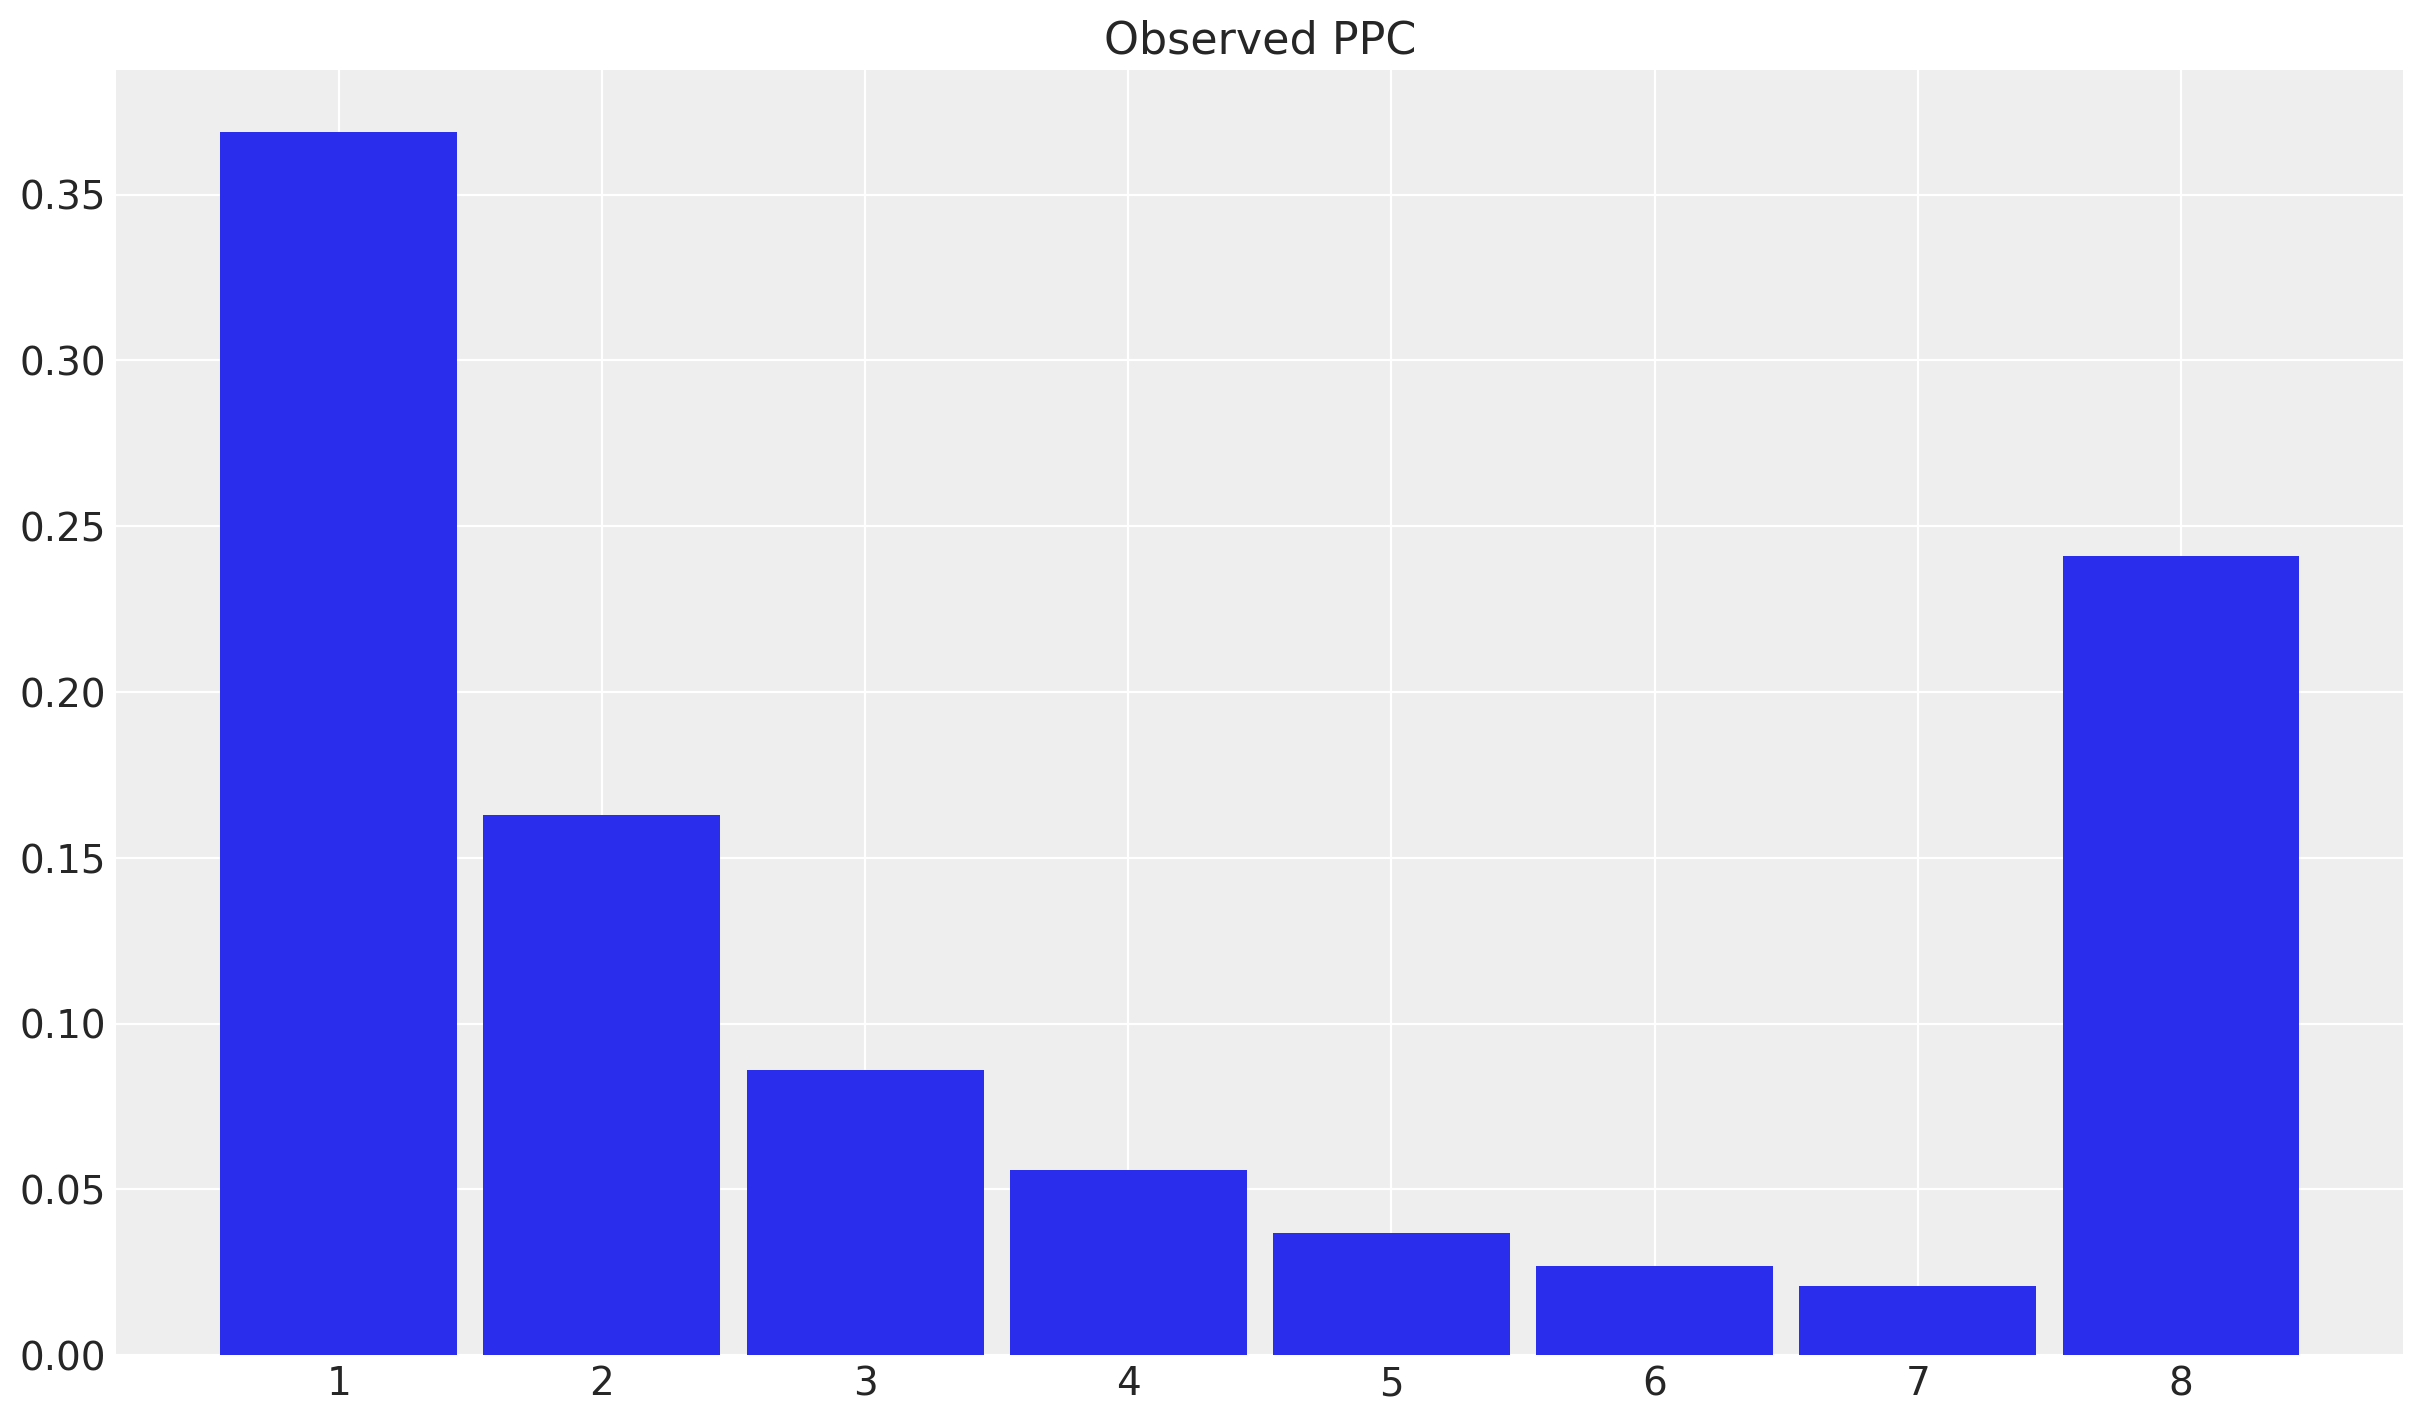

In [148]:
az.plot_dist(reg_data["t_churn"]).set_title("Observed PPC")

# Model Fit with `pm.Potential` and Highend Customers

In [150]:
coords = {
    "churn_customer": hi_data["customer_id"][~hi_censored],
    "active_customer": hi_data["customer_id"][reg_censored],
}

with pm.Model(coords=coords) as model:
    # Independent priors
    # alpha = pm.Gamma("alpha",alpha=1,beta=1)
    # r = pm.Gamma("r", alpha=1,beta=1)

    # Are pooled priors more stable?
    phi = pm.Uniform("phi",lower=0,upper=1)
    kappa = pm.Pareto("kappa",alpha=1,m=1) #m is starting point, and could be good way to constrain to prevent crashes

    alpha=pm.Deterministic("alpha", phi * kappa)
    r=pm.Deterministic("r", (1-phi) * kappa)
    
    churn_raw = clv.distributions.GrassiaIIGeometric("churn",r=r, alpha=alpha, observed = hi_data["t_churn"][~hi_censored], dims=("churn_customer",))
    cens = pm.Potential("censored",log_survival_fn(r, alpha, hi_data["t_churn"][hi_censored]), dims=("active_customer",))

    idata = pm.sample(idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


### Diagnostics and Posterior Predictive Check

In [151]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  1.875  1.595   0.999    3.753      0.039    0.027    1655.0    1440.0   
kappa  1.876  1.595   1.000    3.754      0.039    0.027    1657.0    1434.0   
phi    1.000  0.000   0.999    1.000      0.000    0.000    1465.0    1168.0   
r      0.000  0.000   0.000    0.001      0.000    0.000    1683.0    1345.0   

       r_hat  
alpha    1.0  
kappa    1.0  
phi      1.0  
r        1.0

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>],
      dtype=object)

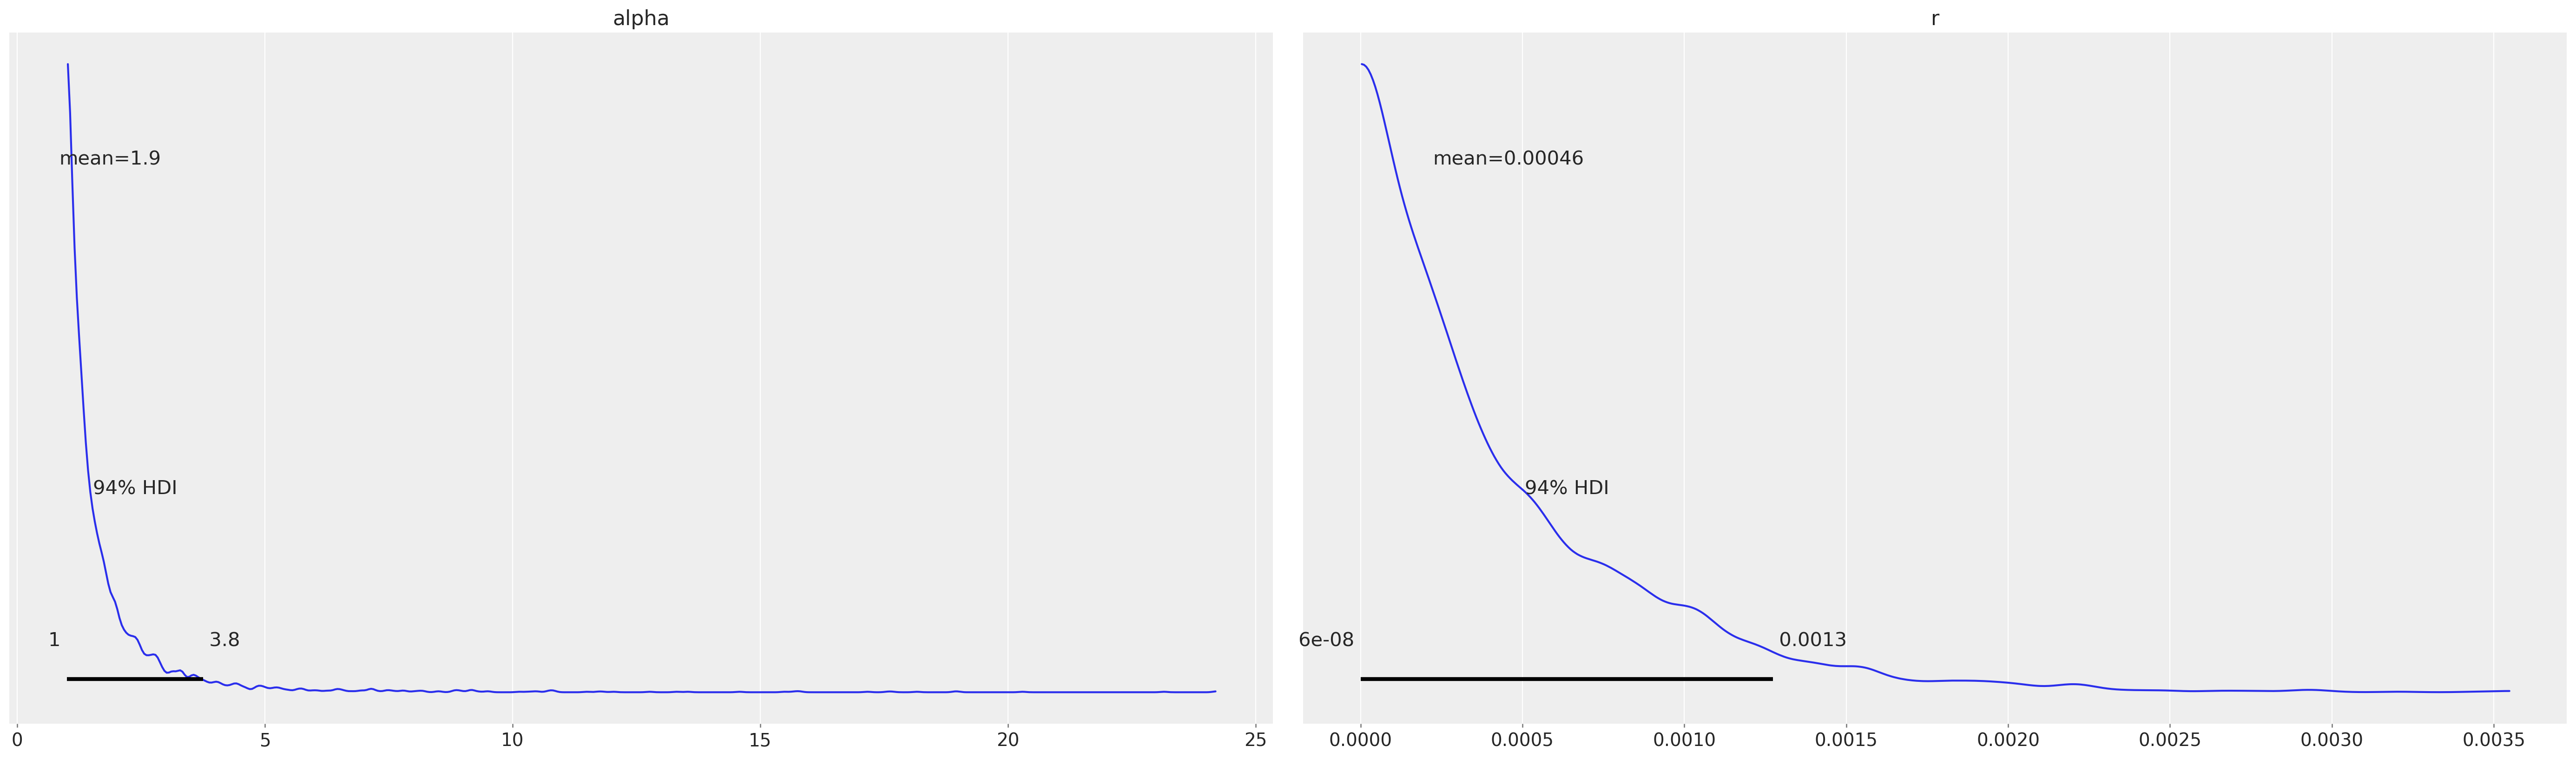

In [152]:
az.plot_posterior(idata, var_names=["alpha","r"])

In [159]:
with model:
    hi_ppc = pm.sample_posterior_predictive(idata)

/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_46755/3922701186.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  hi_ppc = pm.sample_posterior_predictive(idata)
Sampling: [churn]


Output()

ValueError: p <= 0, p > 1 or p contains NaNs
Apply node that caused the error: g2g_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x36AF8AC00>), MakeVector{dtype='int64'}.0, ExpandDims{axis=0}.0, ExpandDims{axis=0}.0)
Toposort index: 3
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,))]
Inputs shapes: ['No shapes', (1,), (1,), (1,)]
Inputs strides: ['No strides', (8,), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x36AF8AC00, array([509]), array([0.00015575]), array([1.28515595])]
Outputs clients: [[output[1](g2g_rv{"(),()->()"}.0)], [output[0](churn)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fg/0gjlwtr11dd51xt6hkb8qw6h0000gn/T/ipykernel_46755/2130618881.py", line 18, in <module>
    churn_raw = clv.distributions.GrassiaIIGeometric("churn",r=r, alpha=alpha, observed = hi_data["t_churn"][~hi_censored], dims=("churn_customer",))
  File "/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/distributions.py", line 973, in dist
    return super().dist([r, alpha], *args, **kwargs)
  File "/Users/coltallen/miniconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)
  File "/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/distributions.py", line 903, in __call__
    return super().__call__(r, alpha, size=size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
# TODO: Do a pandas plot of this!
clipped_ppc_val

In [158]:
hi_ppc_val = hi_ppc.posterior_predictive["churn"].values.flatten()

print(f"data describe: {describe(ppc_val)}")

az.plot_dist(ppc_val[ppc_val<9],color='green').set_title("Synthetic PPC")

NameError: name 'hi_ppc' is not defined

Text(0.5, 1.0, 'Observed PPC')

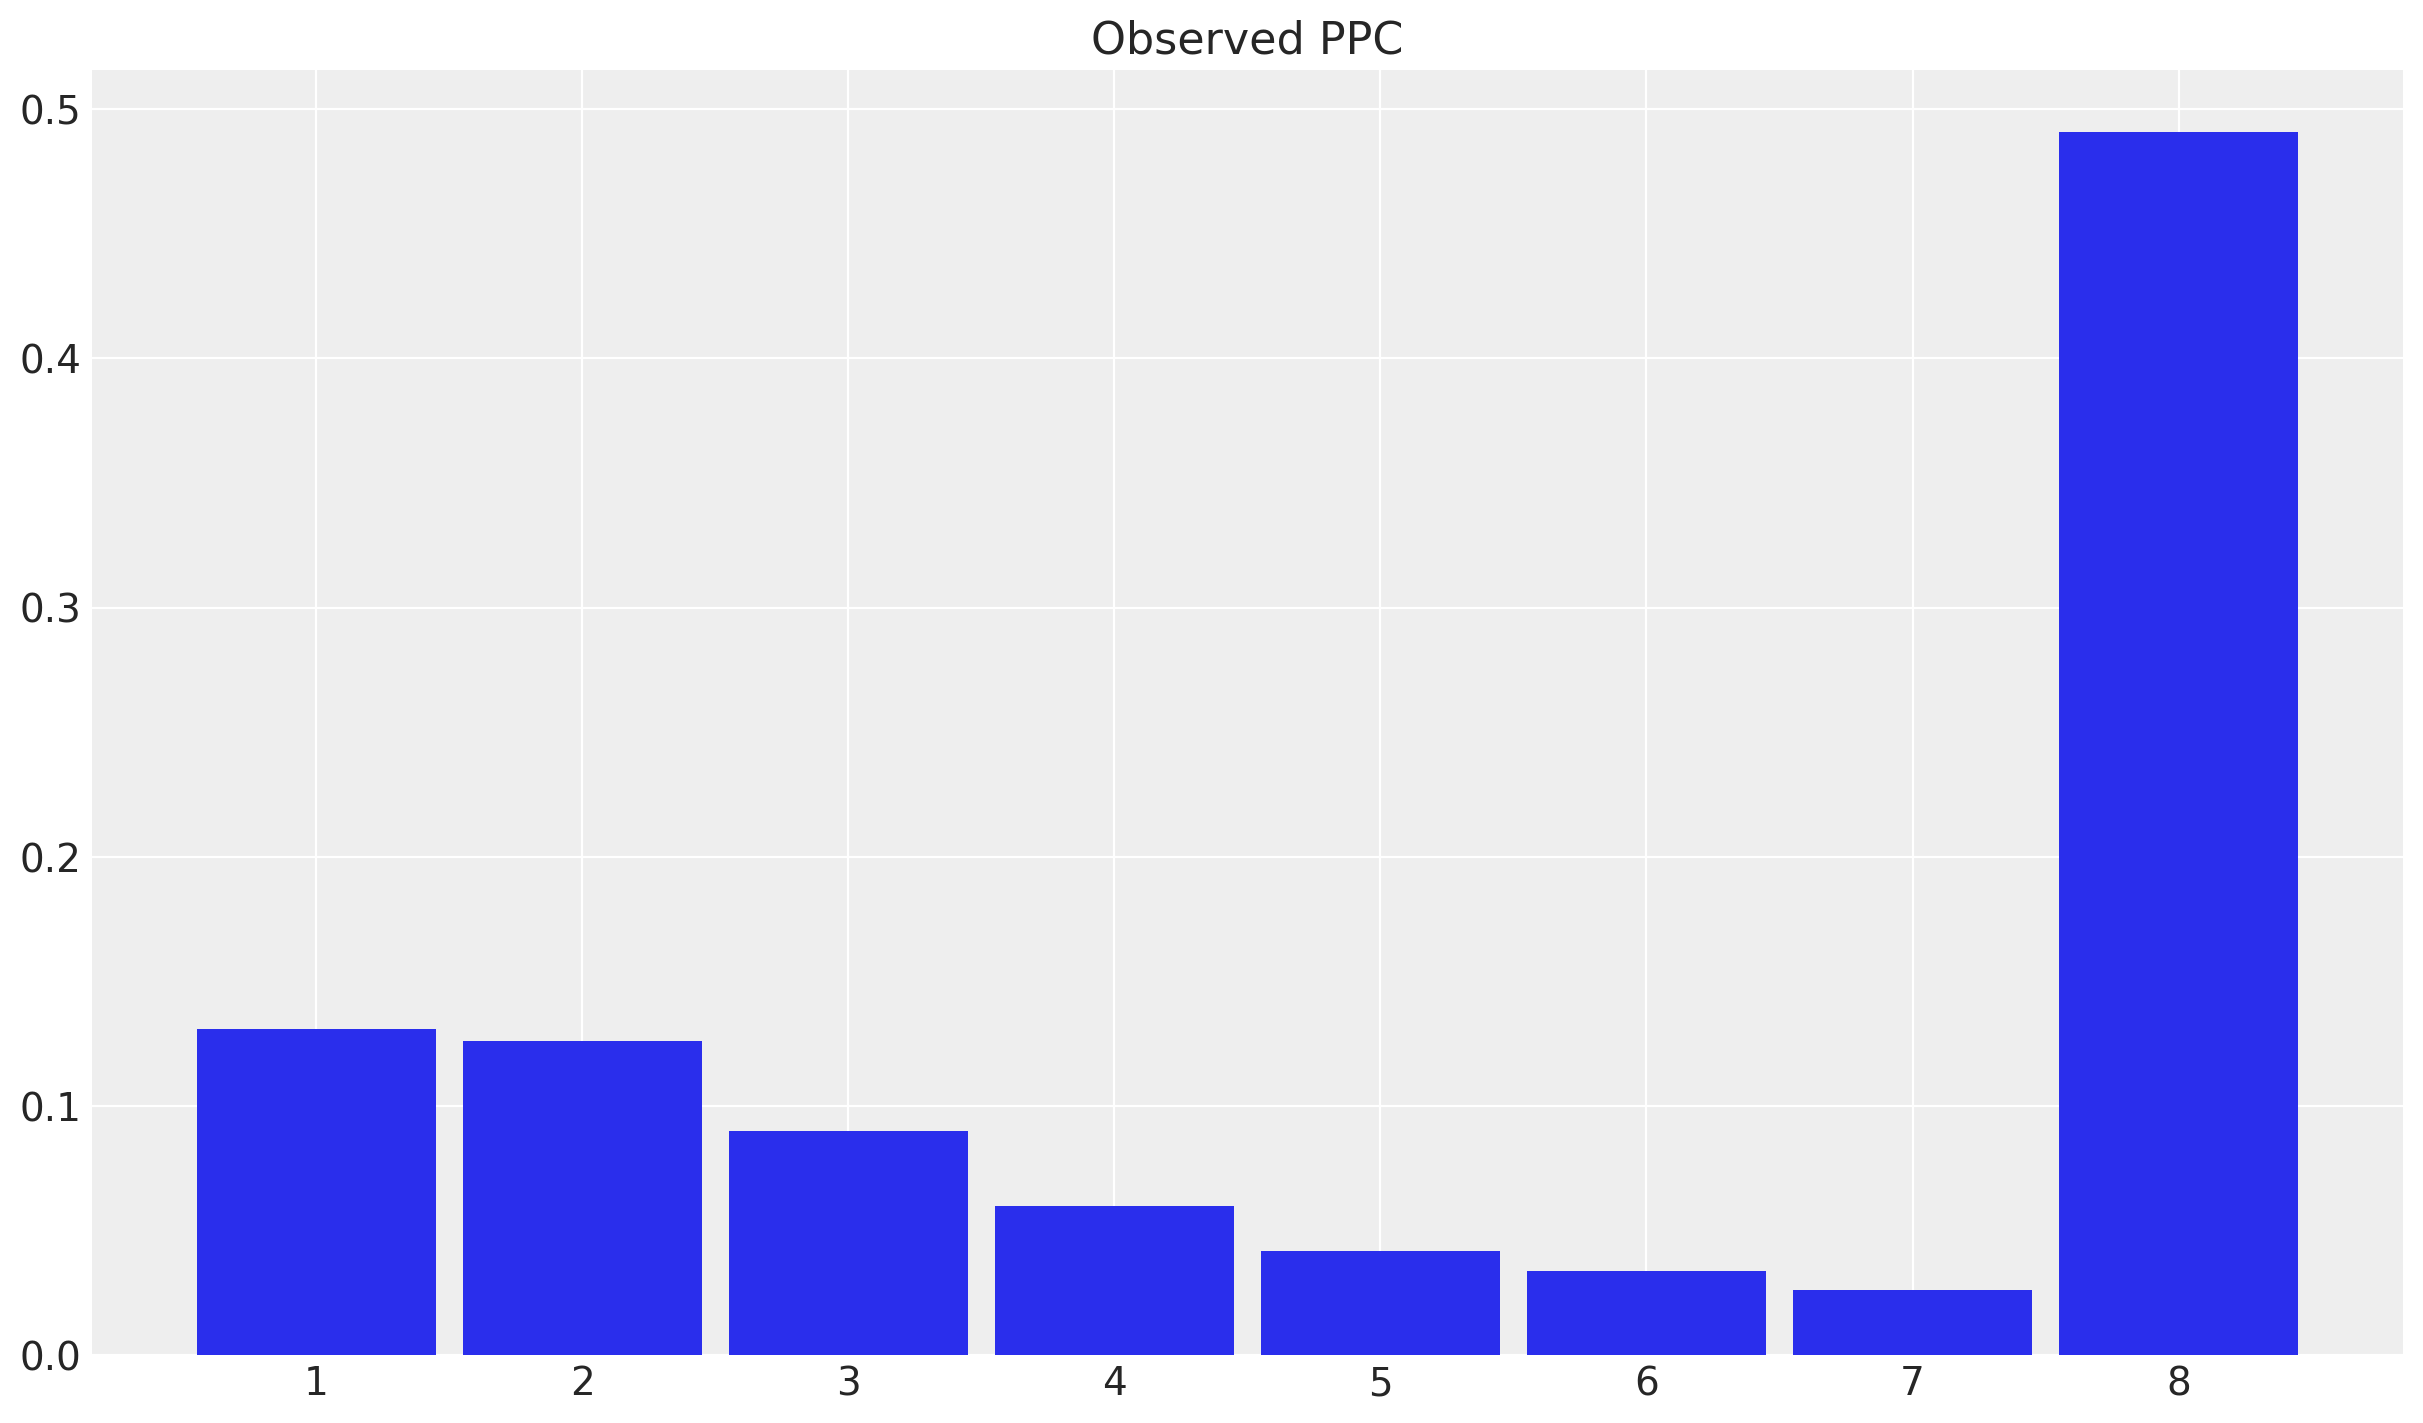

In [157]:
az.plot_dist(hi_data["t_churn"]).set_title("Observed PPC")

# Covariate Data Generation Code
Incorporate this code into the Data Generation section for covariate development.

In [8]:
# Set random seed
rng = np.random.seed(45)

# Number of customers
N = 1000

# customer IDs
customer_id = np.array(np.arange(N))

# define probabiilty distributions
demographic_dist = pm.Bernoulli.dist(p=.5,rng=rng)
t_periods_dist = pm.Geometric.dist(p=.5, rng=rng)
active_dist = pm.Bernoulli.dist(p=.3,rng=rng)
n_purchases_dist = pm.Poisson.dist(mu=1, rng=rng)
avg_purchase_price_dist = pm.Gamma.dist(alpha=10, beta=1, rng=rng)

# draws for each customer
demographic = pm.draw(demographic_dist,draws=N)
t_periods = 13 - pm.draw(t_periods_dist,draws=N)
active = pm.draw(active_dist,draws=N)

In [9]:
# create time periods for each customer
customer_id_col = np.array([])

for idx in zip(customer_id, t_periods):
    customer_id_col = np.concatenate((customer_id_col, np.repeat(idx[0], idx[1])), axis=0)

n_time_periods = len(customer_id_col)

ValueError: negative dimensions are not allowed

In [ ]:
# draws for each time period
n_purchases = pm.draw(n_purchases_dist, draws=n_time_periods)
avg_purchase_price = pm.draw(avg_purchase_price_dist, draws=n_time_periods)

In [ ]:
customer_df = pd.DataFrame(
    {
        "customer_id": customer_id,
        "demographic": demographic,
        "active": active,
    }
)

time_period_df = pd.DataFrame(
    {
        "customer_id": customer_id_col,
        "monthly_purchases": n_purchases,
        "avg_price": avg_purchase_price,
    }
)

In [ ]:
customer_df

In [ ]:
time_period_df